# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, all steps to build and run a traffic sign recognition classifier was developed. 

It was implemented following these steps:
- Step 0: Load the german traffic signs datasets (training, validation and test)
- Step 1: Dataset Summary & Exploration
- Step 2: Design, Train and Evaluate a Model Architecture
- Step 3: Test a Trained Model on New Images
- Step 4: Visualize each Convolutional Layer of the Model on an Image

---
## Step 0: Load the German traffic signs dataset (training, validation and test)

### Import project libraries

In [23]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from tabulate import tabulate
import itertools
import pickle
import math
import time
import csv

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

training_results_filename = "training_results"
arch_names = ["L2_FC1","L2MS_FC1","L3_FC1"]

### Load the pickled dataset

This dataset is available [here](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip) by Udacity

In [24]:
# Load pickled data
import pickle

training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1. Dataset Summary & Exploration

Explore the German Traffic Signs Dataset using the pickled file(s).

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 
    - **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### 1.1. Dataset Summary

In [25]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

# Get Traffic Signs readable names for each class/label
signnames = {}
with open("signnames.csv", 'r') as f:
    signnames_csv = list(csv.reader(f, delimiter=","))[1:]
    signnames = {rows[0]:rows[1] for rows in signnames_csv}

print("Number of training examples \t= {}\t\tdtype:{}".format(n_train,X_train.dtype))
print("Number of validation examples \t= {}\t\tdtype:{}".format(n_validation,X_valid.dtype))
print("Number of testing examples \t= {}\t\tdtype:{}".format(n_test,X_test.dtype))
print("Number of classes \t\t= {}\t\tdtype:{}".format(n_classes,y_train.dtype))
print("\nImage data shape \t\t= {}".format(image_shape))


Number of training examples 	= 34799		dtype:uint8
Number of validation examples 	= 4410		dtype:uint8
Number of testing examples 	= 12630		dtype:uint8
Number of classes 		= 43		dtype:uint8

Image data shape 		= (32, 32, 3)


### 1.2. Classes distribution on the dataset

In [94]:
# Calculate how many images per classes are in each dataset
n_classes_bincount_train = np.bincount(y_train)
n_classes_bincount_valid = np.bincount(y_valid)
n_classes_bincount_test = np.bincount(y_test)

n_classes_ids = np.arange(max(len(n_classes_bincount_train),len(n_classes_bincount_valid),len(n_classes_bincount_test)))
n_classes_names = np.array([signnames[str(i)] for i in range(len(signnames))])

data = np.column_stack((n_classes_ids, n_classes_names, n_classes_bincount_train, n_classes_bincount_valid, n_classes_bincount_test))
headers = ["Classes","Traffic Sign Name","Training\nImages","Validation\nImages","Test\nImages"]

train_dataset_map = tabulate(data, headers, tablefmt="pretty")
print(train_dataset_map)

+---------+----------------------------------------------------+----------+------------+--------+
| Classes |                 Traffic Sign Name                  | Training | Validation |  Test  |
|         |                                                    |  Images  |   Images   | Images |
+---------+----------------------------------------------------+----------+------------+--------+
|    0    |                Speed limit (20km/h)                |   180    |     30     |   60   |
|    1    |                Speed limit (30km/h)                |   1980   |    240     |  720   |
|    2    |                Speed limit (50km/h)                |   2010   |    240     |  750   |
|    3    |                Speed limit (60km/h)                |   1260   |    150     |  450   |
|    4    |                Speed limit (70km/h)                |   1770   |    210     |  660   |
|    5    |                Speed limit (80km/h)                |   1650   |    210     |  630   |
|    6    |         

### 1.2.1. Graphic visualization of images distribuition on the dataset

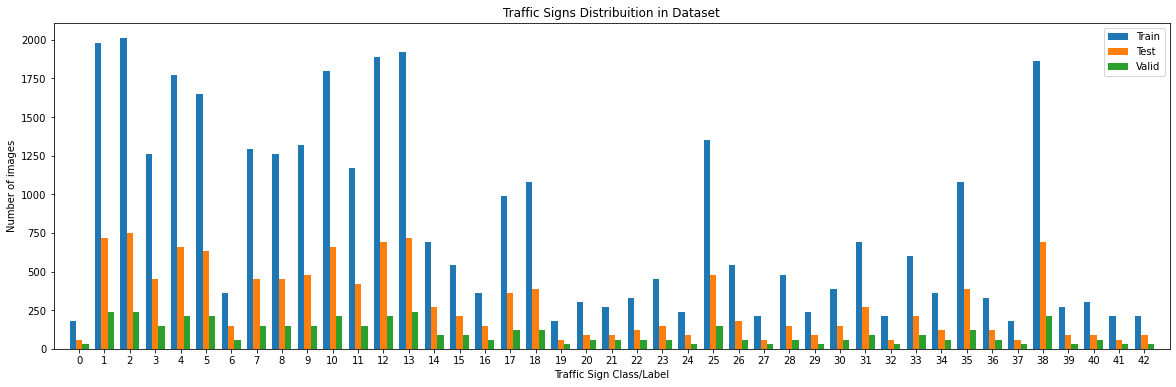

In [27]:
fig = plt.figure(figsize=(20,6))
plt.title("Traffic Signs Distribuition in Dataset")
plt.xlabel('Traffic Sign Class/Label')
plt.ylabel('Number of images')
plt.xlim(-1,max(n_classes_ids)+1)
plt.bar(n_classes_ids-0.25,n_classes_bincount_train,0.25,label = "Train")
plt.bar(n_classes_ids,n_classes_bincount_test,0.25,label = "Test")
plt.bar(n_classes_ids+0.25,n_classes_bincount_valid,0.25,label = "Valid")
plt.xticks(n_classes_ids)
plt.legend()
plt.show()
fig.savefig("output_images/step1_dataset_distribuition.png",bbox_inches='tight')

### 1.3. Visualization of an image of each class/label on the training dataset

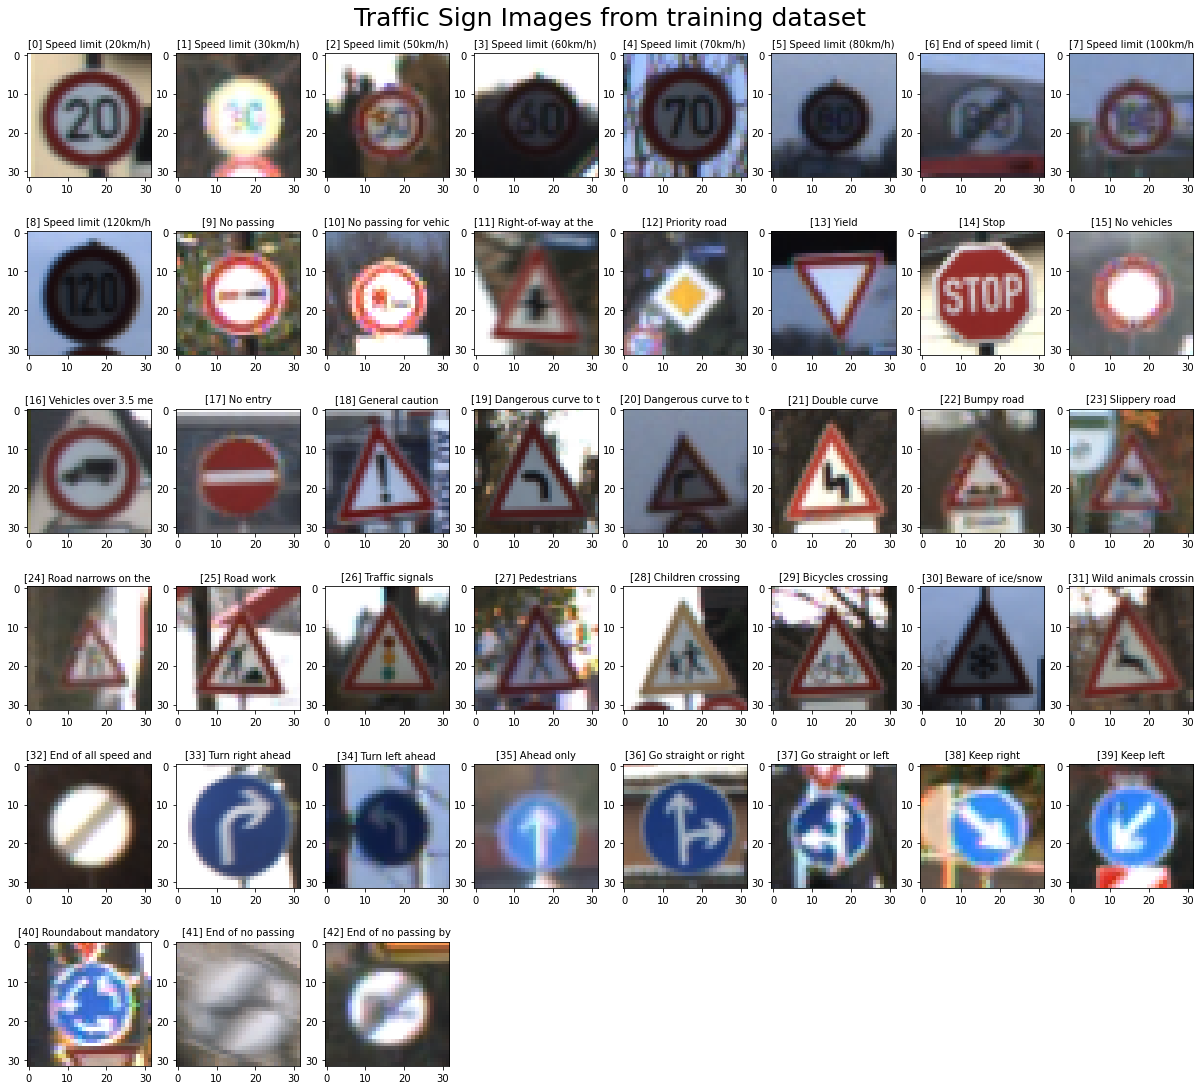

In [9]:
plt_sample=[]
sample_threshold_low = 97
sample_threshold_high = 150

# Get an sample of each sign ID
for i in range(n_classes):
    # Get all indexes of the current class i
    idy = np.where(y_train==i)[0]
    for j in idy:
        # Calculate training image mean value
        m = np.mean(X_train[j])

        # Check image mean value to avoid images that are too bright or too dark
        if m < sample_threshold_high and m > sample_threshold_low:
            # Append train image to the sample list and go for next class search
            plt_sample.append(X_train[j])
            break

# Show images
plt_cols_len = 8
plt_rows_len = n_classes//plt_cols_len +1
plt_fig, plt_ax = plt.subplots(plt_rows_len,plt_cols_len, figsize=(18, 16))
plt_fig.suptitle("Traffic Sign Images from training dataset", fontsize=25)

for j in range(1,plt_rows_len*plt_cols_len - n_classes+1):
    plt_ax[-1,-j].axis('off')
for i in range(len(plt_sample)):
    row = i//plt_cols_len
    col = i%plt_cols_len
    plt_ax[row][col].imshow(plt_sample[i])
    plt_ax[row][col].set_title('[{}] {}'.format(i,signnames[str(i)][:20), fontsize=10)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
# plt.savefig("output_images/step1_traffic_sign_images.png",bbox_inches='tight')

----

## Step 2. Design, Train and Evaluate a Model Architecture
### Project Orientations
Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 2.1. Pre-process the Data Set

The `pre_process_image` receives an image and do the following operations:
- Resize the image to 32x32
- Grayscale the image
- Normalize the image from -1 to 1, so that the data has mean zero and equal variance

Future improvements:
- [Histogram Equalization](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)
- Increase dataset by creating slight rotated image versions

In [28]:
# Pre process the given image
def pre_process_image(img):
    img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    normalized = np.zeros((32,32))
    normalized = cv2.normalize(gray,normalized,-1,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
    return np.expand_dims(normalized,axis=2)

### 2.1.1. Create normalized images arrays (train, validation and test)

In [29]:
# Normalize datasets
X_train_norm = np.array([pre_process_image(xi) for xi in X_train])
X_valid_norm = np.array([pre_process_image(xi) for xi in X_valid])
X_test_norm = np.array([pre_process_image(xi) for xi in X_test])

### 2.1.2. Show a random pre processed image in normalized traing dataset

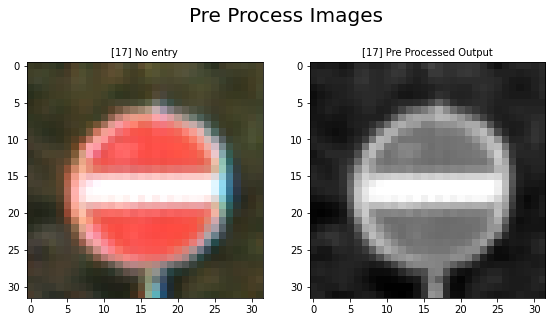

In [92]:
# Show the first image on train dataset grayscaled and normalized
random_index = np.random.choice(n_train)
normalized = pre_process_image(X_train[random_index])

plt_fig, plt_ax = plt.subplots(1,2, figsize=(8, 5))
plt_fig.suptitle("Pre Process Images", fontsize=20)

plt_ax[0].imshow(X_train[random_index])
plt_ax[0].set_title('[{}] {}'.format(y_train[random_index],signnames[str(y_train[random_index])][:15]), fontsize=10)
plt_ax[1].imshow(np.squeeze(normalized,axis=2), cmap='gray')
plt_ax[1].set_title('[{}] Pre Processed Output'.format(y_train[random_index]), fontsize=10)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save results
# plt.savefig("output_images/step2_preprocessed_train_image.png",bbox_inches='tight')

### 2.2. Design Model Architectures

For this project, two Models were designed based on LeNet-5:
- L2_FC1: **2 Convolutional Layers** (Convolution, Activation and Pooling) followed by a **1 Hidden Layer Classifier** (Fully Connected, Activation, Regulatization Dropout and Fully Connected)
- L3_FC1: **3 Convolutional Layers** (Convolution, Activation and Pooling) followed by a **1 Hidden Layer Classifier** (Fully Connected, Activation, Regulatization Dropout and Fully Connected)


In [31]:
# 2 Conv Layers + Classifier 1 Hidden layer
def L2_FC1(x, params):
    mu = 0
    sigma = 0.1

    # Conv Layer 1: Convolutional. Input = 32x32x1.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(params["l1_hw"], params["l1_hw"], params["l1_di"], params["l1_do"]), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(params["l1_do"]))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, params["l1_st"], params["l1_st"], 1], padding='VALID') + conv1_b
    print("{} Conv Layer 1: Convolutional \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv1.shape))
    
    # Conv Layer 1: Activation.
    conv1 = tf.nn.relu(conv1)

    # Conv Layer 1: Pooling.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, params["l1_mp_ks"], params["l1_mp_ks"], 1], strides=[1, params["l1_mp_st"], params["l1_mp_st"], 1], padding='VALID')
    print("{} Conv Layer 1: Max Pooling \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv1.shape))

    # Conv Layer 2: Convolutional.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(params["l2_hw"], params["l2_hw"], params["l1_do"], params["l2_do"]), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(params["l2_do"]))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, params["l2_st"], params["l2_st"], 1], padding='VALID') + conv2_b
    print("{} Conv Layer 2: Convolutional \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv2.shape))

    # Conv Layer 2: Activation.
    conv2 = tf.nn.relu(conv2)

    # Conv Layer 2: Pooling. 
    conv2 = tf.nn.max_pool(conv2, ksize=[1, params["l2_mp_ks"], params["l2_mp_ks"], 1], strides=[1, params["l2_mp_st"], params["l2_mp_st"], 1], padding='VALID')
    print("{} Conv Layer 2: Max Pooling \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv2.shape))

    # Conv Layer 2: Flatten.
    fc0   = flatten(conv2)
    print("{} Conv Layer 2: Flatten \t\t\t\t| Output size:{}".format(arch_names[params["arch"]],fc0.shape))

    # Check if Classifier is 1 or 2 layers
    if(params["lfc1_d"] == 0):
        # Classifier Layer 1: Fully Connected.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(int(fc0.shape[1]), n_classes), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(n_classes))
        logits   = tf.matmul(fc0, fc1_W) + fc1_b
        print("{} Classifier Layer 1: Fully Connected \t\t| Output size:{}".format(arch_names[params["arch"]],logits.shape))

        return logits       

    else:
        # Classifier Layer 1: Fully Connected.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(int(fc0.shape[1]), params["lfc1_d"]), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(params["lfc1_d"]))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        print("{} Classifier Layer 1: Fully Connected \t\t| Output size:{}".format(arch_names[params["arch"]],fc1.shape))
        
        # Classifier Layer 1: Activation.
        fc1    = tf.nn.relu(fc1)

        # Classifier Layer 1: Regulatization Dropout
        if params["reg_kp"] > 0:
            fc1 = tf.nn.dropout(fc1, params["reg_kp"])
            print("{} Classifier Layer 1: Regulatization Dropout \t| Output size:{}".format(arch_names[params["arch"]],fc1.shape))

        # Classifier Layer 2: Fully Connected.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(params["lfc1_d"], n_classes), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(n_classes))
        logits = tf.matmul(fc1, fc2_W) + fc2_b
        print("{} Classifier Layer 2: Fully Connected \t\t| Output size:{}".format(arch_names[params["arch"]],logits.shape))
        
        return logits, conv1, conv2

In [32]:
# 3 Conv Layers + Classifier 1 Hidden layer
def L3_FC1(x, params):
    mu = 0
    sigma = 0.1

    # Conv Layer 1: Convolutional. Input = 32x32x1.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(params["l1_hw"], params["l1_hw"], params["l1_di"], params["l1_do"]), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(params["l1_do"]))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, params["l1_st"], params["l1_st"], 1], padding='VALID') + conv1_b
    print("{} Conv Layer 1: Convolutional \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv1.shape))
    
    # Conv Layer 1: Activation.
    conv1 = tf.nn.relu(conv1)

    # Conv Layer 1: Pooling.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, params["l1_mp_ks"], params["l1_mp_ks"], 1], strides=[1, params["l1_mp_st"], params["l1_mp_st"], 1], padding='VALID')
    print("{} Conv Layer 1: Max Pooling \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv1.shape))

    # Conv Layer 2: Convolutional.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(params["l2_hw"], params["l2_hw"], params["l1_do"], params["l2_do"]), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(params["l2_do"]))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, params["l2_st"], params["l2_st"], 1], padding='VALID') + conv2_b
    print("{} Conv Layer 2: Convolutional \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv2.shape))

    # Conv Layer 2: Activation.
    conv2 = tf.nn.relu(conv2)

    # Conv Layer 2: Pooling. 
    conv2 = tf.nn.max_pool(conv2, ksize=[1, params["l2_mp_ks"], params["l2_mp_ks"], 1], strides=[1, params["l2_mp_st"], params["l2_mp_st"], 1], padding='VALID')
    print("{} Conv Layer 2: Max Pooling \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv2.shape))

    # Conv Layer 3: Convolutional.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(params["l3_hw"], params["l3_hw"], params["l2_do"], params["l3_do"]), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(params["l3_do"]))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, params["l3_st"], params["l3_st"], 1], padding='VALID') + conv3_b
    print("{} Conv Layer 3: Convolutional \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv3.shape))

    # Conv Layer 3: Activation.
    conv3 = tf.nn.relu(conv3)

    # Conv Layer 3: Pooling. 
    conv3 = tf.nn.max_pool(conv3, ksize=[1, params["l3_mp_ks"], params["l3_mp_ks"], 1], strides=[1, params["l3_mp_st"], params["l3_mp_st"], 1], padding='VALID')
    print("{} Conv Layer 3: Max Pooling \t\t\t| Output size:{}".format(arch_names[params["arch"]],conv3.shape))

    # Conv Layer 3: Flatten.
    fc0   = flatten(conv3)
    print("{} Conv Layer 3: Flatten \t\t\t\t| Output size:{}".format(arch_names[params["arch"]],fc0.shape))

    # Check if Classifier is 1 or 2 layers
    if(params["lfc1_d"] == 0):
        # Classifier Layer 1: Fully Connected.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(int(fc0.shape[1]), n_classes), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(n_classes))
        logits   = tf.matmul(fc0, fc1_W) + fc1_b
        print("{} Classifier Layer 1: Fully Connected \t\t| Output size:{}".format(arch_names[params["arch"]],logits.shape))

        return logits       

    else:
        # Classifier Layer 1: Fully Connected.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(int(fc0.shape[1]), params["lfc1_d"]), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(params["lfc1_d"]))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        print("{} Classifier Layer 1: Fully Connected \t\t| Output size:{}".format(arch_names[params["arch"]],fc1.shape))
        
        # Classifier Layer 1: Activation.
        fc1    = tf.nn.relu(fc1)

        # Classifier Layer 1: Regulatization Dropout
        if params["reg_kp"] > 0:
            fc1 = tf.nn.dropout(fc1, params["reg_kp"])
            print("{} Classifier Layer 1: Regulatization Dropout \t| Output size:{}".format(arch_names[params["arch"]],fc1.shape))

        # Classifier Layer 2: Fully Connected.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(params["lfc1_d"], n_classes), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(n_classes))
        logits = tf.matmul(fc1, fc2_W) + fc2_b
        print("{} Classifier Layer 2: Fully Connected \t\t| Output size:{}".format(arch_names[params["arch"]],logits.shape))
        
        return logits, conv1, conv2, conv3

## 2.3. Full training and evaluation pipeline

### 2.3.1. Define functions to save and show training results

To help evaluating multiple training parameters and models, the following functions were defined. 
- `save_training_results()` saves `params` variable (that contains all training params + training results) on a file using numpy `savetxt` function.
- `print_training_results` shows the training results ordered by test_accuracy column.

In [33]:
def save_training_results(params):
    headers = ["duration","valid_acc","test_acc","arch","EPOCH","BATCH_SIZE","RATE","l1_hw","l1_di","l1_do","l1_st","l1_mp_ks","l1_mp_st","l2_hw","l2_do","l2_st","l2_mp_ks","l2_mp_st","l2b_mp_ks","l2b_mp_st","l3_hw","l3_do","l3_st","l3_mp_ks","l3_mp_st","lfc1_d","lfc2_d","reg_kp"]

    row = []
    for h in range(len(headers)):
        if headers[h] in params:
            row.append(params[headers[h]])
        else:
            row.append(-1)
    
    current_training_results = np.array(row)
    try:
        training_results = np.loadtxt('{}.csv'.format(training_results_filename),delimiter=',')
        current_training_results = np.vstack((current_training_results,training_results))
        np.savetxt('{}.csv'.format(training_results_filename), current_training_results, fmt='%.4f', delimiter=',')
        print("Results saved in {}.csv".format(training_results_filename))
    # If any error occurs, save in a new file
    except:
        print("Creating a new training_results.csv")
        np.savetxt("{}_{}.csv".format(training_results_filename,int(time.time())), current_training_results, fmt='%.4f', delimiter=',')

    
# Load training results
def print_training_results(params=[{}], load=False, sort_column=2, max_rows=20, headers=[]):
    if(load):
        try:
            training_data = np.loadtxt('{}.csv'.format(training_results_filename), delimiter=',')
            if len(training_data.shape) == 1:
                training_data = np.expand_dims(training_data,axis=0)
            else:
                training_data = training_data[training_data[:,sort_column].argsort()][::-1][:max_rows]
            headers_full = ["duration","valid_acc","test_acc","arch","EPOCH","BATCH_SIZE","RATE","l1_hw","l1_di","l1_do","l1_st","l1_mp_ks","l1_mp_st","l2_hw","l2_do","l2_st","l2_mp_ks","l2_mp_st","l2b_mp_ks","l2b_mp_st","l3_hw","l3_do","l3_st","l3_mp_ks","l3_mp_st","lfc1_d","lfc2_d","reg_kp"]
            params = []
            for i in range(len(training_data)):
                p = {}
                for j in range(len(training_data[i])):
                    p[headers_full[j]] = training_data[i][j]
                params.append(p)
        except:
            print("Couldn't load {}.csv".format(training_results_filename))
    
    if type(params) != list:
        params = [params]

    # Check if is to show all headers
    if len(headers) == 0:
        headers = ["duration","valid_acc","test_acc","arch","EPOCH","BATCH_SIZE","RATE","l1_hw","l1_di","l1_do","l1_st","l1_mp_ks","l1_mp_st","l2_hw","l2_do","l2_st","l2_mp_ks","l2_mp_st","l2b_mp_ks","l2b_mp_st","l3_hw","l3_do","l3_st","l3_mp_ks","l3_mp_st","lfc1_d","lfc2_d","reg_kp"]

    training_data = []
    for i in range(len(params)):
        p = params[i]
        row = []
        for h in range(len(headers)):
            if headers[h] in p:
                if headers[h] == "arch" and p[headers[h]] >=0 and p[headers[h]] < len(arch_names):
                    row.append(arch_names[int(p[headers[h]])])
                elif headers[h] == "duration":
                    row.append(time.strftime("%H:%M:%S", time.gmtime(p[headers[h]])))
                else:
                    row.append(p[headers[h]])
            else:
                row.append("")
        training_data.append(row)
            
    training_table = tabulate(training_data, headers, tablefmt="pretty")
    print(training_table)

print_training_results(load=True, headers = ["duration","valid_acc","test_acc","arch","l1_hw","l1_do","l2_hw","l2_do","l3_hw","l3_do","lfc1_d","reg_kp","EPOCH","BATCH_SIZE","RATE"])

+----------+-----------+----------+--------+-------+-------+-------+-------+-------+-------+--------+--------+-------+------------+--------+
| duration | valid_acc | test_acc |  arch  | l1_hw | l1_do | l2_hw | l2_do | l3_hw | l3_do | lfc1_d | reg_kp | EPOCH | BATCH_SIZE |  RATE  |
+----------+-----------+----------+--------+-------+-------+-------+-------+-------+-------+--------+--------+-------+------------+--------+
| 00:49:39 |   0.975   |  0.949   | L3_FC1 |  3.0  | 32.0  |  3.0  | 64.0  |  3.0  | 256.0 | 100.0  |  0.7   | 100.0 |   128.0    | 0.0005 |
| 00:37:01 |   0.969   |  0.943   | L3_FC1 |  3.0  | 32.0  |  3.0  | 64.0  |  3.0  | 256.0 | 100.0  |  0.7   | 75.0  |   128.0    | 0.0005 |
| 00:23:34 |   0.96    |   0.94   | L3_FC1 |  3.0  | 32.0  |  3.0  | 64.0  |  3.0  | 256.0 | 100.0  |  0.7   | 50.0  |   128.0    | 0.0005 |
| 00:17:41 |   0.955   |   0.94   | L2_FC1 |  7.0  | 16.0  |  5.0  | 64.0  |  3.0  | 256.0 | 100.0  |  0.7   | 50.0  |   128.0    | 0.0005 |
| 00:08:59 | 

### 2.3.2. Define a full customizable training function

The `full_train_eval()` is a complete customizable training and evaluation pipeline that executes training based on the `params` variable given as argument. When argument `save_model` is set `True`, the model variables are saved in `trained_models` folder with filenames as thefollowing pattern: `arch_name`_`duration`

In [34]:
def full_train_eval(params,save_model=False):
    # dataset variables that will be shuffled
    global X_train_norm
    global X_train
    global y_train
    
    tf.reset_default_graph()
    
    # Features and Labels
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, n_classes)

    # Training Pipeline - Select archtecture accordingly with param 'arch'
    if params["arch"] == arch_names.index("L2_FC1"):
        logits = L2_FC1(x, params)[0]
    elif params["arch"] == arch_names.index("L3_FC1"):
        logits = L3_FC1(x, params)[0]
    else:
        logits = LeNetT2(x, params)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = params["RATE"])
    training_operation = optimizer.minimize(loss_operation)

    # Model Evaluation
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    if(save_model):
        saver = tf.train.Saver()

    def evaluate(X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, params["BATCH_SIZE"]):
            batch_x, batch_y = X_data[offset:offset+params["BATCH_SIZE"]], y_data[offset:offset+params["BATCH_SIZE"]]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

    # Start TF Session to train, validate and test the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        ts_start = time.time()
        print("\n\n### Start Training {}\t at time: {} GMT\n".format(full_training_i,time.strftime("%H:%M:%S", time.gmtime(ts_start))))

        validation_accuracy = 0.0
        for i in range(params["EPOCH"]):
            X_train_norm, X_train, y_train = shuffle(X_train_norm, X_train, y_train)
            for offset in range(0, n_train, params["BATCH_SIZE"]):
                end = offset + params["BATCH_SIZE"]
                batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                
            validation_accuracy = evaluate(X_valid_norm, y_valid)

            print("EPOCH: {}\t| Time elapsed: {}\t| Validation Accuracy = {:.3f}".format(i+1,time.strftime("%H:%M:%S", time.gmtime(time.time()-ts_start)),validation_accuracy))
        
        test_accuracy = evaluate(X_test_norm, y_test)
        print("\nFinal Validation Accuracy \t= {:.3f}".format(validation_accuracy))
        print("      Test Accuracy \t\t= {:.3f}\n".format(test_accuracy))

        # Calcualte final duration
        time_elapsed = time.time()-ts_start

        # Save training params
        params["valid_acc"] = round(validation_accuracy,3)
        params["test_acc"]  = round(test_accuracy,3)
        params["duration"]  = round(time_elapsed,2)
        save_training_results(params)

        # Show current training results
        print_training_results([params],load=False, headers = ["duration","valid_acc","test_acc","arch","l1_hw","l1_do","l2_hw","l2_do","l3_hw","l3_do","lfc1_d","reg_kp","EPOCH","BATCH_SIZE","RATE"])
        
        # Save trained model
        if(save_model):
            saver.save(sess,"trained_models/{}_{}".format(arch_names[params["arch"]],str(int(params["duration"]*100))))

        print("\n\n### Finish Training {}\t at time: {} GMT\n".format(full_training_i,time.strftime("%H:%M:%S", time.gmtime(time.time()))))

    return True

### 2.3.3. Execute `full_train_eval()` on each combination of parameters

An array for each parameters is defined, a list of all parameters combinations are made and then `full_train_eval()` is execute with each of them sequentially.

In [27]:
# Each parameter values that will be combine to build the training queue
arch_arr = [arch_names.index("L3_FC1")]

EPOCH_arr = [75,100]
BATCH_SIZE_arr = [128]
RATE_arr = [0.0005]

l1_hw_arr = [3]
l1_di_arr = [1]
l1_do_arr = [32]
l1_st_arr = [1]
l1_mp_ks_arr = [2]
l1_mp_st_arr = [2]

l2_hw_arr = [3]
l2_do_arr = [64]
l2_st_arr = [1]
l2_mp_ks_arr = [2]
l2_mp_st_arr = [2]

l2b_mp_ks_arr = [4]
l2b_mp_st_arr = [4]

l3_hw_arr = [3]
l3_do_arr = [256]
l3_st_arr = [1]
l3_mp_ks_arr = [2]
l3_mp_st_arr = [2]

lfc1_d_arr = [100]
lfc2_d_arr = [101]
reg_kp_arr = [0.7]

params = [arch_arr,EPOCH_arr,BATCH_SIZE_arr,RATE_arr,l1_hw_arr,l1_di_arr,l1_do_arr,l1_st_arr,l1_mp_ks_arr,l1_mp_st_arr,l2_hw_arr,l2_do_arr,l2_st_arr,l2_mp_ks_arr,l2_mp_st_arr,l2b_mp_ks_arr,l2b_mp_st_arr,l3_hw_arr,l3_do_arr,l3_st_arr,l3_mp_ks_arr,l3_mp_st_arr,lfc1_d_arr,lfc2_d_arr,reg_kp_arr]

# Build a list with all possible combinations from params arrays
training_list = list(itertools.product(*params))

full_training_i = 0
for p in training_list:
    params = {
        "arch": p[0],
        "EPOCH": p[1],
        "BATCH_SIZE": p[2],
        "RATE": p[3],
        "l1_hw": p[4],
        "l1_di": p[5],
        "l1_do": p[6],
        "l1_st": p[7],
        "l1_mp_ks": p[8],
        "l1_mp_st": p[9],
        "l2_hw": p[10],
        "l2_do": p[11],
        "l2_st": p[12],
        "l2_mp_ks": p[13],
        "l2_mp_st": p[14],
        "l2b_mp_ks": p[15],
        "l2b_mp_st": p[16],
        "l3_hw": p[17],
        "l3_do": p[18],
        "l3_st": p[19],
        "l3_mp_ks": p[20],
        "l3_mp_st": p[21],
        "lfc1_d": p[22],
        "lfc2_d": p[23],
        "reg_kp": p[24]
    }
    full_training_i += 1

    print("\n### Start Full Training-evaluation iteration {}".format(full_training_i))
    print("\nparams = ".format(params))
    print("\n### Training Archtecture {}:\n".format(arch_names[params["arch"]]))
    full_train_eval(params,save_model=True)

{'arch': 2, 'EPOCH': 75, 'BATCH_SIZE': 128, 'RATE': 0.0005, 'l1_hw': 3, 'l1_di': 1, 'l1_do': 32, 'l1_st': 1, 'l1_mp_ks': 2, 'l1_mp_st': 2, 'l2_hw': 3, 'l2_do': 64, 'l2_st': 1, 'l2_mp_ks': 2, 'l2_mp_st': 2, 'l2b_mp_ks': 4, 'l2b_mp_st': 4, 'l3_hw': 3, 'l3_do': 256, 'l3_st': 1, 'l3_mp_ks': 2, 'l3_mp_st': 2, 'lfc1_d': 100, 'lfc2_d': 101, 'reg_kp': 0.7}
L3_FC1 Conv Layer 1: Convolutional 			| Output size:(?, 30, 30, 32)
L3_FC1 Conv Layer 1: Max Pooling 			| Output size:(?, 15, 15, 32)
L3_FC1 Conv Layer 2: Convolutional 			| Output size:(?, 13, 13, 64)
L3_FC1 Conv Layer 2: Max Pooling 			| Output size:(?, 6, 6, 64)
L3_FC1 Conv Layer 3: Convolutional 			| Output size:(?, 4, 4, 256)
L3_FC1 Conv Layer 3: Max Pooling 			| Output size:(?, 2, 2, 256)
L3_FC1 Conv Layer 3: Flatten 				| Output size:(?, 1024)
L3_FC1 Classifier Layer 1: Fully Connected 		| Output size:(?, 100)
L3_FC1 Classifier Layer 1: Regulatization Dropout 	| Output size:(?, 100)
L3_FC1 Classifier Layer 2: Fully Connected 		| Outpu

### 2.3.4. Show trainig results ordered by test accuracy

In [35]:
print_training_results(load=True, headers = ["duration","valid_acc","test_acc","arch","l1_hw","l1_do","l2_hw","l2_do","l3_hw","l3_do","lfc1_d","EPOCH","BATCH_SIZE","RATE"])

+----------+-----------+----------+--------+-------+-------+-------+-------+-------+-------+--------+-------+------------+--------+
| duration | valid_acc | test_acc |  arch  | l1_hw | l1_do | l2_hw | l2_do | l3_hw | l3_do | lfc1_d | EPOCH | BATCH_SIZE |  RATE  |
+----------+-----------+----------+--------+-------+-------+-------+-------+-------+-------+--------+-------+------------+--------+
| 00:49:39 |   0.975   |  0.949   | L3_FC1 |  3.0  | 32.0  |  3.0  | 64.0  |  3.0  | 256.0 | 100.0  | 100.0 |   128.0    | 0.0005 |
| 00:37:01 |   0.969   |  0.943   | L3_FC1 |  3.0  | 32.0  |  3.0  | 64.0  |  3.0  | 256.0 | 100.0  | 75.0  |   128.0    | 0.0005 |
| 00:23:34 |   0.96    |   0.94   | L3_FC1 |  3.0  | 32.0  |  3.0  | 64.0  |  3.0  | 256.0 | 100.0  | 50.0  |   128.0    | 0.0005 |
| 00:17:41 |   0.955   |   0.94   | L2_FC1 |  7.0  | 16.0  |  5.0  | 64.0  |  3.0  | 256.0 | 100.0  | 50.0  |   128.0    | 0.0005 |
| 00:08:59 |   0.953   |  0.934   | L3_FC1 |  3.0  | 16.0  |  3.0  | 64.0  |

---

## Step 3. Test a Model on New Images

To get new German traffic sign images, Google street views was opened on roads near `Maximilianeum ` in Munich, Germany, to take screenshots of traffic signs and save them in `test_images` folder. The filenames pattern used is: `[sign class]`_`[place name]`.png

These images has to be pre processed (load, crop, grayscale and normalize) to build the new test arrays (X_test_new,X_test_new_norm and y_test_new).

The right model from training step is selected, then a pipeline is built use the selected model to predict the traffic sign type.


### 3.1. Pre process the new set of Images

In [37]:
# get the new test images filenames available in the folde
test_img_files = os.listdir("test_images/")

# New test datasets
X_test_new = []
X_test_new_norm = []
y_test_new = []

# Define crop params to crop images by image filename: img_name:[x0,y0,offset]
crop_params = {
    #
    "1_munich.png":[10,5,100],
    "2_munich.png":[50,35,225],
    "11_munich.png":[60,20,140],
    "12_munich.png":[55,15,175],
    "13_munich.png":[45,40,250],
    "15_munich.png":[30,25,135],
    "17_munich.png":[35,20,80],
    "26_munich.png":[20,0,200],
    "27_munich.png":[35,15,175],
    "29_munich.png":[75,30,190],
    "33_munich.png":[100,50,240],
    "35_munich.png":[45,30,175],
    "36_munich.png":[20,20,220],
    "38_munich.png":[50,50,190],
    "38_munich2.png":[150,75,325],
    "39_munich.png":[30,25,100],
}

# Load, crop and process each image in test_images folder to build new test arrays
for f in test_img_files:
    img = mpimg.imread("test_images/{}".format(f))

    if(f in crop_params):
        c = crop_params[f]
        img = img[c[1]:(c[1]+c[2]),c[0]:(c[0]+c[2])]
    img_norm = pre_process_image(img)

    X_test_new.append(img)
    X_test_new_norm.append(img_norm)
    y_test_new.append(int(f.split('_')[0]))

X_test_new = np.array(X_test_new)
X_test_new_norm = np.array(X_test_new_norm)
y_test_new = np.array(y_test_new)

# Order by traffic sign IDs
order = y_test_new.argsort()
X_test_new = X_test_new[order]
X_test_new_norm = X_test_new_norm[order]
y_test_new = y_test_new[order]

### 3.1.1. Visualize the new dataset of images 

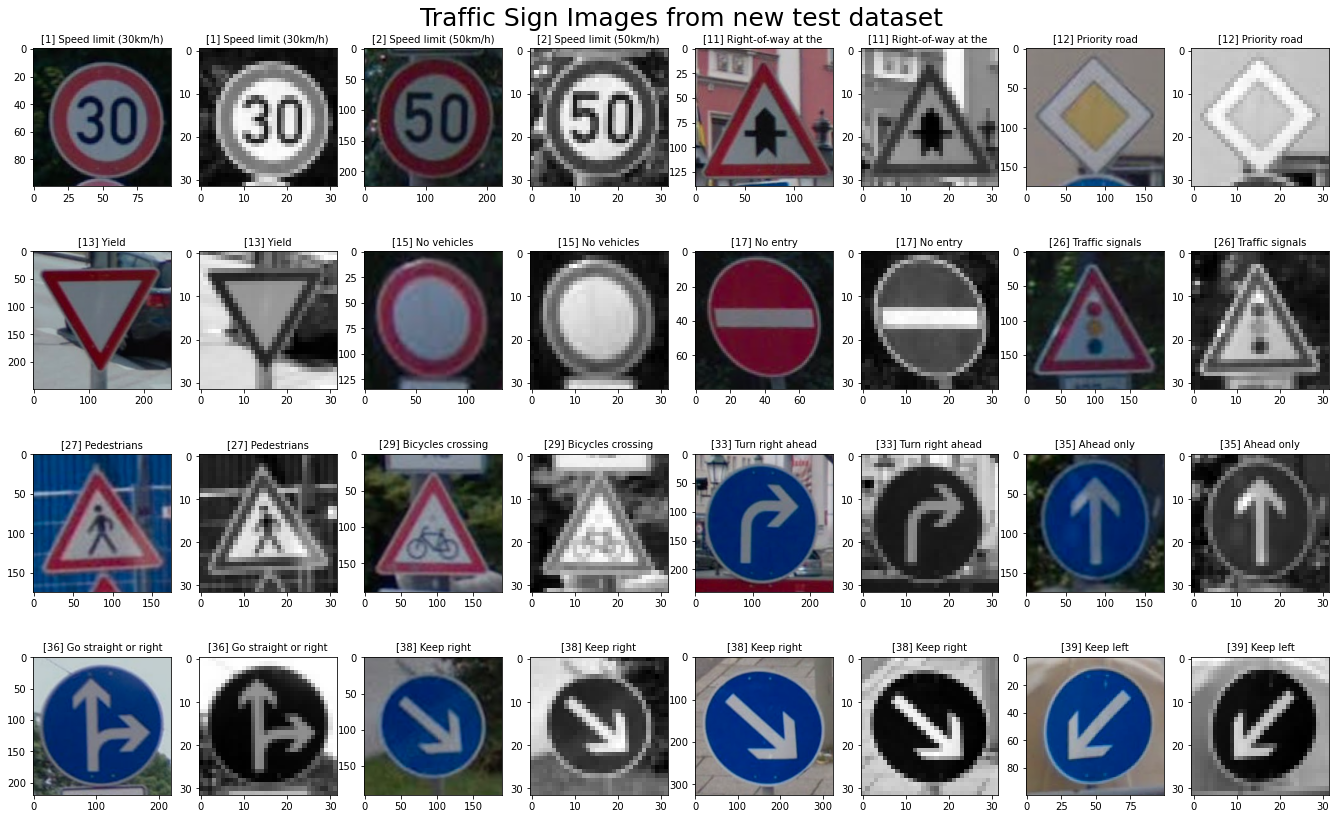

In [39]:
# Show images and the corresponded normalized images besides
plt_cols_len = 8
plt_rows_len = len(test_img_files)

plt_fig, plt_ax = plt.subplots(math.ceil(plt_rows_len/(plt_cols_len//2)),plt_cols_len, figsize=(20,12))
plt_fig.suptitle("Traffic Sign Images from new test dataset", fontsize=25)

for k in range(len(test_img_files)):
    i = k//(plt_cols_len//2)
    j = k%(plt_cols_len//2)
    plt_ax[i][j*2].imshow(X_test_new[k])
    plt_ax[i][j*2].set_title('[{}] {}'.format(y_test_new[k],signnames[str(y_test_new[k])][:20]), fontsize=10)
    plt_ax[i][j*2+1].imshow(np.squeeze(X_test_new_norm[k],axis=2),cmap="gray")
    plt_ax[i][j*2+1].set_title('[{}] {}'.format(y_test_new[k],signnames[str(y_test_new[k])][:20]), fontsize=10)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save results
# plt.savefig("output_images/step3_preprocessed_new_dataset.png")

### 3.2. Choose a trained model and set its parameters
* Models are saved in folder `trained_models`
* The params of the chosen model can be found in `training_results.csv`, in the section `2.3.4` or printed in the training output in section `2.3.3` 

In [18]:
trained_model_filename = "L3_FC1_297939"
test_params = {'arch': 2, 'EPOCH': 100, 'BATCH_SIZE': 128, 'RATE': 0.0005, 'l1_hw': 3, 'l1_di': 1, 'l1_do': 32, 'l1_st': 1, 'l1_mp_ks': 2, 'l1_mp_st': 2, 'l2_hw': 3, 'l2_do': 64, 'l2_st': 1, 'l2_mp_ks': 2, 'l2_mp_st': 2, 'l2b_mp_ks': 4, 'l2b_mp_st': 4, 'l3_hw': 3, 'l3_do': 256, 'l3_st': 1, 'l3_mp_ks': 2, 'l3_mp_st': 2, 'lfc1_d': 100, 'lfc2_d': 101, 'reg_kp': 0.7}
n_classes = 43

### 3.3. Build the prediction pipeline based on test parameters

In [19]:
# Reset graph
tf.reset_default_graph()

# Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Select archtecture accordingly with param 'arch'
if test_params["arch"] == arch_names.index("L2_FC1"):
    logits,conv1,conv2 = L2_FC1(x, test_params)
elif test_params["arch"] == arch_names.index("L3_FC1"):
    logits,conv1,conv2,conv3 = L3_FC1(x, test_params)
else:
    logits = L2_FC1(x, test_params)

softmax_logits = tf.nn.softmax(logits)
softmax_top5 = tf.nn.top_k(softmax_logits, k=5)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

L3_FC1 Conv Layer 1: Convolutional 			| Output size:(?, 30, 30, 32)
L3_FC1 Conv Layer 1: Max Pooling 			| Output size:(?, 15, 15, 32)
L3_FC1 Conv Layer 2: Convolutional 			| Output size:(?, 13, 13, 64)
L3_FC1 Conv Layer 2: Max Pooling 			| Output size:(?, 6, 6, 64)
L3_FC1 Conv Layer 3: Convolutional 			| Output size:(?, 4, 4, 256)
L3_FC1 Conv Layer 3: Max Pooling 			| Output size:(?, 2, 2, 256)
L3_FC1 Conv Layer 3: Flatten 				| Output size:(?, 1024)
L3_FC1 Classifier Layer 1: Fully Connected 		| Output size:(?, 100)
L3_FC1 Classifier Layer 1: Regulatization Dropout 	| Output size:(?, 100)
L3_FC1 Classifier Layer 2: Fully Connected 		| Output size:(?, 43)


### 3.4. Predict the Sign Type for Each Image

* `test_predictions` variable will be populated with each image prediction array, following this pattern:
 
 \[ `test image index`, `test image class/label`, `prediction results` \]

In [20]:
test_predictions = []
# Start tf session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Restore pre trained model
    saver2 = tf.train.Saver()
    saver2.restore(sess, "trained_models/"+trained_model_filename)
    print("Model {} restored".format(trained_model_filename))

    print("\n### Start predicting on new test set with a size of {} images".format(len(X_test_new_norm)))
    
    # Iterate over all test images
    for i in range(len(X_test_new_norm)):
        prediction = sess.run(softmax_top5, feed_dict={x:[ X_test_new_norm[i]], y: [y_test_new[i]]})
        test_predictions.append([i,y_test_new[i],prediction])
    
print("\n### Finished {} predictions".format(len(test_predictions)))

INFO:tensorflow:Restoring parameters from trained_models/L3_FC1_297939
Model L3_FC1_297939 restored

### Start predicting on new test set with a size of 16 images

### Finished 16 predictions


### 3.5. Analyze Performance

In [21]:
# Calculate based on the test_predictions array of results built in the previous step
performance = 100.0 * sum([ sign_id == pred_sign_id[1][0][0] for _,sign_id,pred_sign_id in test_predictions ]) / len(test_predictions)

print("Test preformance with model {} is {:.2f}%".format(trained_model_filename, performance))

Test preformance with model L3_FC1_297939 is 100.00%


In [22]:
# Calculate performance using tensorflow functions
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Restore pre trained model
    saver2 = tf.train.Saver()
    saver2.restore(sess, "trained_models/"+trained_model_filename)
    print("Model {} restored".format(trained_model_filename))

    accuracy = sess.run(accuracy_operation, feed_dict={x: X_test_new_norm, y: y_test_new})
    print("\nTest preformance with model {} is {:.2f}%".format(trained_model_filename, accuracy*100))

INFO:tensorflow:Restoring parameters from trained_models/L3_FC1_297939
Model L3_FC1_297939 restored

Test preformance with model L3_FC1_297939 is 100.00%


### 3.6. Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [23]:
# Prepare test predictions results to show in tabulate
test_data = []
for i in range(len(test_predictions)):
    test_data.append([
        test_predictions[i][0],
        signnames[str(test_predictions[i][1])],
        test_predictions[i][1],
        "{:<2d} [{:.1e}]".format(test_predictions[i][2][1][0][0],test_predictions[i][2][0][0][0]),
        "{:<2d} [{:.1e}]".format(test_predictions[i][2][1][0][1],test_predictions[i][2][0][0][1]),
        "{:<2d} [{:.1e}]".format(test_predictions[i][2][1][0][2],test_predictions[i][2][0][0][2]),
        "{:<2d} [{:.1e}]".format(test_predictions[i][2][1][0][3],test_predictions[i][2][0][0][3]),
        "{:<2d} [{:.1e}]".format(test_predictions[i][2][1][0][4],test_predictions[i][2][0][0][4]),
    ])

# Define headers
test_headers = ["Test\nImg #","Sign Name","Sign\nType","1st Softmax \nPredition","2st Softmax \nPredition","3st Softmax \nPredition","4st Softmax \nPredition","5st Softmax \nPredition"]

# Create table of results   
test_table = tabulate(test_data, test_headers, tablefmt="pretty")

print("Test results with model: {}".format(trained_model_filename))
print(test_table)

Test results with model: L3_FC1_297939
+-------+---------------------------------------+------+--------------+--------------+--------------+--------------+--------------+
| Test  |               Sign Name               | Sign | 1st Softmax  | 2st Softmax  | 3st Softmax  | 4st Softmax  | 5st Softmax  |
| Img # |                                       | Type |  Predition   |  Predition   |  Predition   |  Predition   |  Predition   |
+-------+---------------------------------------+------+--------------+--------------+--------------+--------------+--------------+
|   0   |         Speed limit (30km/h)          |  1   | 1  [1.0e+00] | 2  [1.3e-23] | 0  [2.0e-35] | 3  [0.0e+00] | 4  [0.0e+00] |
|   1   |         Speed limit (50km/h)          |  2   | 2  [1.0e+00] | 1  [1.1e-17] | 40 [5.1e-28] | 37 [5.3e-31] | 21 [7.7e-33] |
|   2   | Right-of-way at the next intersection |  11  | 11 [1.0e+00] | 30 [1.7e-11] | 21 [4.9e-17] | 40 [2.6e-21] | 42 [1.1e-22] |
|   3   |             Priority road  

### 3.8. Test on a single image
- This section shows an individual prediction, showing the test image with its results 

In [26]:
# Load an knwon test image
f = "1_munich.png"
test_img_path = "test_images/{}".format(f)

In [25]:
# Or choose an untrained image
f = "3_unknown.png"
test_img_path = "test_unknown_images/{}".format(f)

INFO:tensorflow:Restoring parameters from trained_models/L3_FC1_297939
Model L3_FC1_297939 restored

### Start predicting for 1_munich.png

### Finished, showing prediction results below:



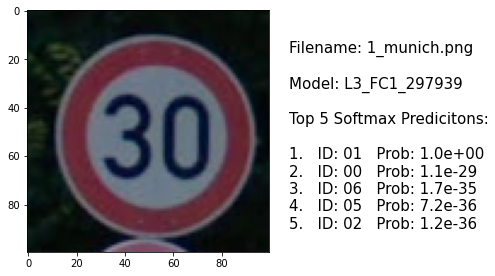

In [27]:
# Load image
test_img = mpimg.imread(test_img_path)

# Pre process image
if(f in crop_params):
    c = crop_params[f]
    test_img = test_img[c[1]:(c[1]+c[2]),c[0]:(c[0]+c[2])]

test_img_norm = pre_process_image(test_img)

# Start tf session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Restore pre trained model
    saver2 = tf.train.Saver()
    saver2.restore(sess, "trained_models/"+trained_model_filename)
    print("Model {} restored".format(trained_model_filename))

    print("\n### Start predicting for {}".format(f))
    
    # Get this image prediction
    prediction = sess.run(softmax_top5, feed_dict={x:[test_img_norm]})
    
print("\n### Finished, showing prediction results below:\n")

plt_fig, plt_ax = plt.subplots(1,1, figsize=(7,4))

plt_ax.imshow(test_img)

# Build the text with results to be drawn beside the tested image
prob_text = "Filename: {}".format(f)
prob_text += "\n\nModel: {}".format(trained_model_filename)
prob_text += "\n\nTop 5 Softmax Predicitons:\n\n"
for i in range(len(prediction[1][0])):
    prob_text += "{}.   ID: {:0>2d}   Prob: {:.1e}\n".format(i+1,prediction[1][0][i],prediction[0][0][i]) 
plt.figtext(0.57,0.1,prob_text,size=15.0)
plt.subplots_adjust(left=0.05, right=0.53, top=1.0, bottom=0.0)

# Save results
plt.savefig("output_images/{}_{}.png".format(f.split('.')[0],trained_model_filename))

---

## Step 4. Visualize the Neural Network's State with Test Images

### Project Orientations
This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

### 4.1. Define `outputFeatureMap()` function to visualize the given layer

In [61]:
# Visualize the network's feature maps 
#   image_input: the test image being fed into the network to produce the feature maps
#   tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
#   layer_i: the correspondent layer name/id, just to write title
#   activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
#   plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, layer_i, image_filename, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt_fig = plt.figure(plt_num, figsize=(15,math.ceil(featuremaps*2.6/8)))
    plt_fig.suptitle("Output FeatureMap of Conv Layer {} for '{}'".format(layer_i,image_filename), fontsize=25)
    for featuremap in range(featuremaps):
        plt.subplot(math.ceil(featuremaps/8),8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

### 4.2. Visualize the Neural Network 

INFO:tensorflow:Restoring parameters from trained_models/L3_FC1_297939
Model L3_FC1_297939 restored


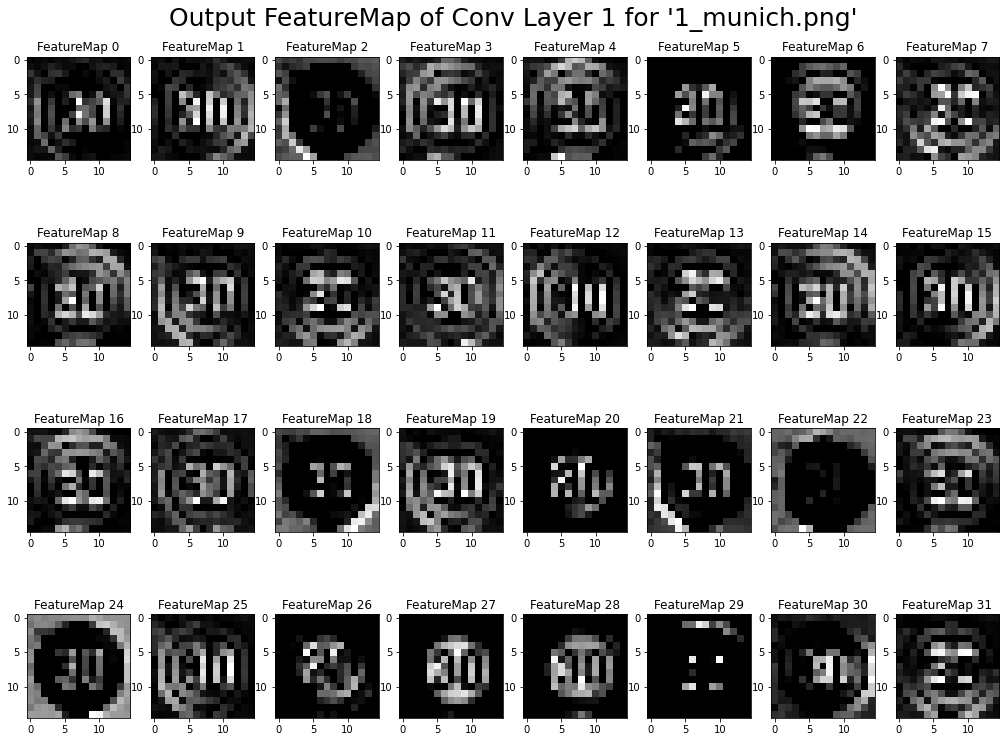

In [60]:
# Start tf session

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Restore pre trained model
    saver2 = tf.train.Saver()
    saver2.restore(sess, "trained_models/"+trained_model_filename)
    print("Model {} restored".format(trained_model_filename))

    # Generate featureMap for ConvNet layer 1
    outputFeatureMap([test_img_norm],conv1,1,f)
    # plt.savefig("output_images/{}_{}_{}.png".format(f.split('.')[0],trained_model_filename,"conv1"))
    
    # Generate featureMap for ConvNet layer 2
    # outputFeatureMap([test_img_norm],conv2,2,f)
    # plt.savefig("output_images/{}_{}_{}.png".format(f.split('.')[0],trained_model_filename,"conv2"))